# Lab. 5 - Using link functions to create generalized linear models
## Patryk Chorąży, 402569

In [225]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from cmdstanpy import CmdStanModel


### 1. Load the data from *Airline_data.csv*

In [226]:
# Load the dataset
Airline_data = pd.read_csv('Airline_data.csv')

In [227]:
Airline_data

,Year,Fatal accidents,Passenger deaths,Miles flown [100 mln miles]
0,1976,24,734,3863.0
1,1977,25,516,4300.0
2,1978,31,754,5027.0
3,1979,31,877,5481.0
4,1980,22,814,5814.0
5,1981,21,362,6033.0
6,1982,26,764,5877.0
7,1983,20,809,6223.0
8,1984,16,223,7433.0
9,1985,22,1066,7107.0


In [228]:
Airline_data.describe()

,Year,Fatal accidents,Passenger deaths,Miles flown [100 mln miles]
count,10.00000,10.000000,10.000000,10.000000
mean,1980.50000,23.800000,691.900000,5715.800000
std,3.02765,4.709329,252.389228,1117.767795
min,1976.00000,16.000000,223.000000,3863.000000
25%,1978.25000,21.250000,570.500000,5140.500000
50%,1980.50000,23.000000,759.000000,5845.500000
75%,1982.75000,25.750000,812.750000,6175.500000
max,1985.00000,31.000000,1066.000000,7433.000000


## Model 1: Half-normal distribution of number of accidents in one year

In [229]:
model_1 = CmdStanModel(stan_file='poisson_model_1.stan')

R = 1000
model_1_sim = model_1.sample(data={'M': 1}, iter_sampling=R,
                     iter_warmup=0,
                     chains=1,
                     fixed_param=True,
                     seed=19042023,
                     refresh=R)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


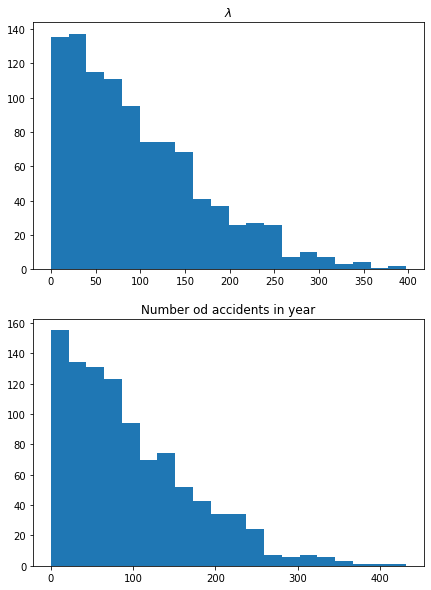

In [230]:
model_1_df = model_1_sim.draws_pd()

lam = model_1_df['lambda']
y_sim = model_1_df['y_sim[1]']

fig,ax = plt.subplots(2,1, figsize=(7,10))
ax[0].hist(lam, bins=20)
ax[0].set_title("$\lambda$")
ax[1].hist(y_sim, bins=20)
ax[1].set_title("Number od accidents in year")
plt.show()

## Model 2: $y_i = Poisson(\lambda)$

This is the simplest model for predicting number of fatal accidents in year. It is based on $\lambda$ parameter represented by half-normal with standard deviation = 121.

In [231]:
model_2 = CmdStanModel(stan_file='poisson_model_2.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [232]:
sim_2 = model_2.sample(data=dict(M = len(Airline_data), y = Airline_data['Fatal accidents']), seed=19042023)

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed

chain 3 |██████████| 00:00 Sampling completed


chain 4 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


In [233]:
sim_2_df = sim_2.draws_pd()
sim_2_df.head()

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,lambda,y_sim[1],y_sim[2],y_sim[3],y_sim[4],y_sim[5],y_sim[6],y_sim[7],y_sim[8],y_sim[9],y_sim[10]
0,518.921,0.843851,1.15889,1.0,3.0,0.0,-518.881,25.6540,17.0,28.0,24.0,16.0,24.0,19.0,34.0,23.0,23.0,26.0
1,519.440,0.968906,1.15889,1.0,3.0,0.0,-518.902,23.2213,19.0,12.0,21.0,25.0,22.0,22.0,25.0,25.0,25.0,28.0
2,519.363,0.990990,1.15889,2.0,3.0,0.0,-519.361,24.8198,24.0,32.0,31.0,18.0,23.0,29.0,27.0,21.0,18.0,29.0
3,519.363,0.707809,1.15889,1.0,1.0,0.0,-518.771,24.8198,24.0,28.0,28.0,28.0,23.0,19.0,29.0,24.0,29.0,21.0
4,518.956,0.859582,1.15889,1.0,1.0,0.0,-518.924,25.6022,25.0,21.0,34.0,31.0,19.0,20.0,26.0,19.0,25.0,33.0


In [234]:
lam = sim_2_df['lambda']
y_sim = sim_2_df['y_sim[1]']

print('Mean of lambda = ', np.mean(lam))

Mean of lambda =  23.888914474999996


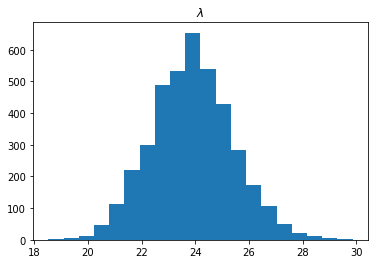

In [235]:
plt.hist(lam, bins=20)
plt.title("$\lambda$")
plt.show()

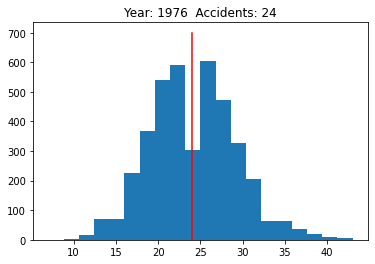

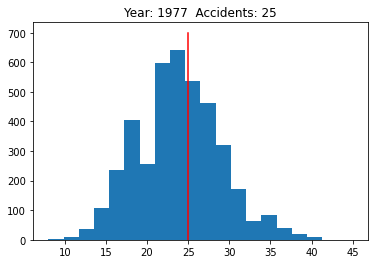

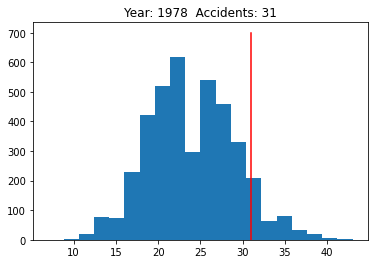

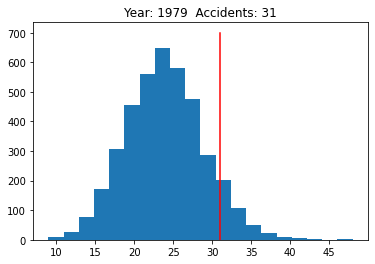

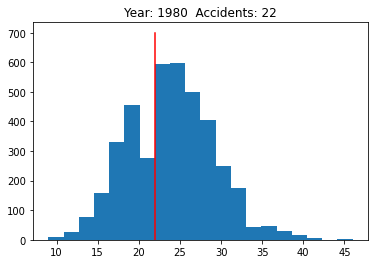

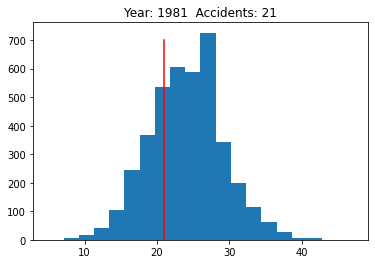

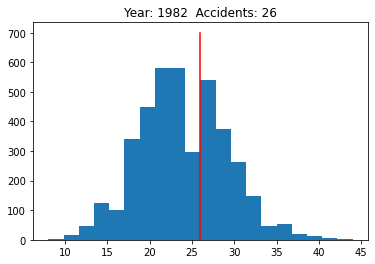

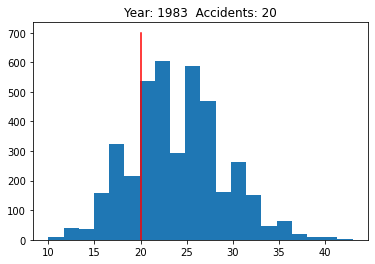

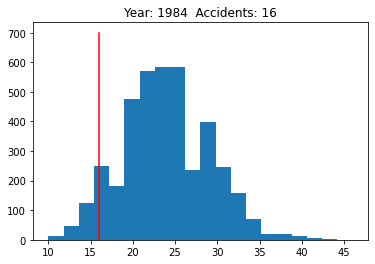

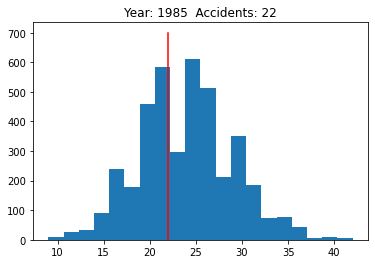

In [236]:
fatal_accidents = Airline_data['Fatal accidents']
years = Airline_data['Year']
for i in range(len(Airline_data)):
    sample = 'y_sim[' + str(i+1) +']'
    plt.hist(sim_2_df[sample], bins=20)
    plt.plot([fatal_accidents[i], fatal_accidents[i]],[0, 700], 'r-')
    plt.title("Year: " + str(years[i]) + "  Accidents: " + str(fatal_accidents[i]))
    plt.show()

In many cases, prediction is close to real value of accidents in each year.

## Model 3: $y_i = Poisson(\theta n_i)$  (Including the ammount of miles flown that year)

This kind of model is predicting number of fatal accidents in each year based on amount of miles flown in particular year. This model has an additional parameter $\theta$.

In [237]:
model_3 = CmdStanModel(stan_file='poisson_model_3.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [238]:
sim_3 = model_3.sample(data=dict(M = len(Airline_data), ni = Airline_data['Miles flown [100 mln miles]']),
                     seed=19042023)

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed

chain 3 |██████████| 00:00 Sampling completed


chain 4 |██████████| 00:00 Sampling completed

INFO:cmdstanpy:CmdStan done processing.


In [239]:
sim_3_df = sim_3.draws_pd()
sim_3_df.head()

,lp__,accept_stat__,theta,y_sim[1],y_sim[2],y_sim[3],y_sim[4],y_sim[5],y_sim[6],y_sim[7],y_sim[8],y_sim[9],y_sim[10]
0,0.0,0.0,0.004352,12.0,24.0,19.0,23.0,28.0,24.0,30.0,27.0,27.0,26.0
1,0.0,0.0,0.019309,79.0,76.0,87.0,96.0,100.0,117.0,118.0,104.0,139.0,156.0
2,0.0,0.0,0.010774,40.0,51.0,52.0,55.0,64.0,57.0,59.0,72.0,82.0,74.0
3,0.0,0.0,0.008235,35.0,30.0,47.0,55.0,31.0,42.0,54.0,39.0,47.0,74.0
4,0.0,0.0,0.000665,4.0,4.0,3.0,2.0,2.0,3.0,4.0,7.0,8.0,4.0


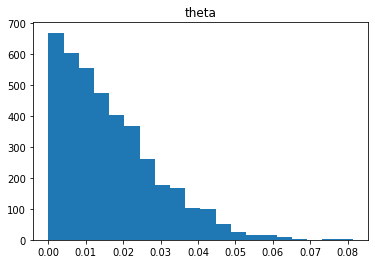

In [240]:
theta = sim_3_df['theta']
plt.hist(theta, bins=20)
plt.title("theta")
plt.show()

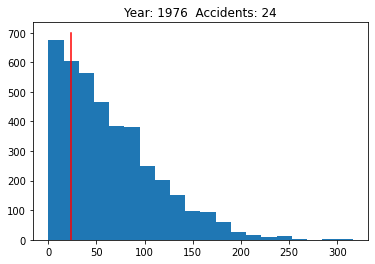

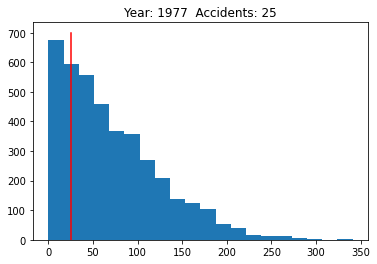

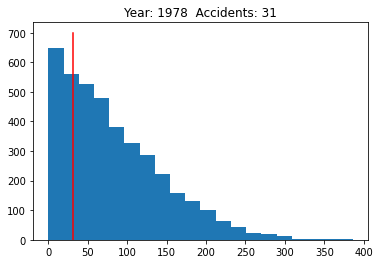

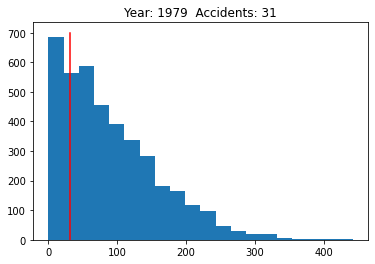

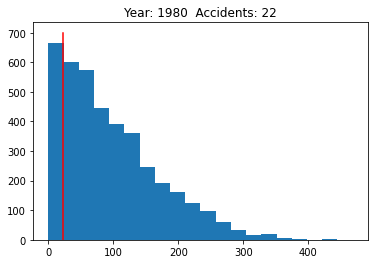

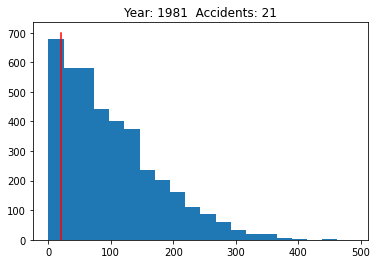

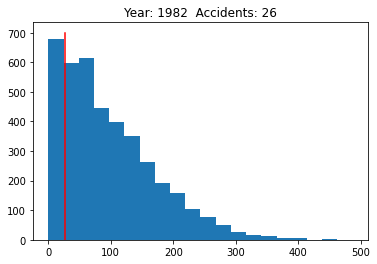

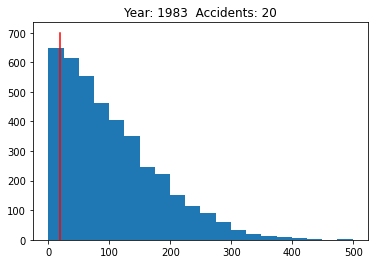

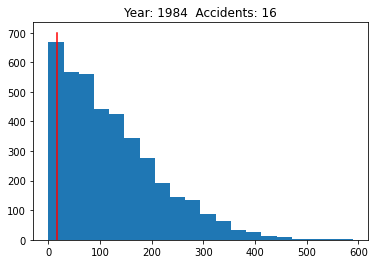

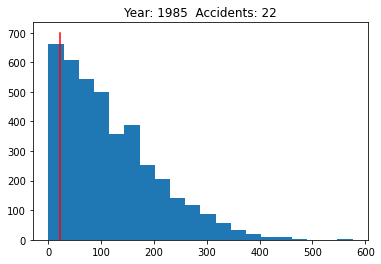

In [241]:
fatal_accidents = Airline_data['Fatal accidents']
years = Airline_data['Year']
for i in range(len(Airline_data)):
    sample = 'y_sim[' + str(i+1) +']'
    plt.hist(sim_3_df[sample], bins=20)
    plt.plot([fatal_accidents[i], fatal_accidents[i]],[0, 700], 'r-')
    plt.title("Year: " + str(years[i]) + "  Accidents: " + str(fatal_accidents[i]))
    plt.show()

## Model 4: $y_i = Poisson(exp(\alpha + \theta n_i))$

In [242]:
model_4 = CmdStanModel(stan_file='poisson_model_4.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [243]:
#alpha = np.mean(Airline_data['Miles flown [100 mln miles]']
sim_4 = model_4.sample(data=dict(M = len(Airline_data), ni = Airline_data['Miles flown [100 mln miles]'], yi = Airline_data['Fatal accidents'], alpha=0),
                     seed=19042023)

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


In [244]:
sim_4_df = sim_4.draws_pd()
sim_4_df.head()

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,theta,y_sim[1],y_sim[2],y_sim[3],y_sim[4],y_sim[5],y_sim[6],y_sim[7],y_sim[8],y_sim[9],y_sim[10]
0,501.134,1.000000,0.918554,1.0,1.0,0.0,-500.794,0.003832,21.0,19.0,18.0,22.0,19.0,23.0,23.0,18.0,35.0,37.0
1,501.842,0.915152,0.918554,1.0,3.0,0.0,-500.097,0.004341,25.0,21.0,20.0,22.0,27.0,28.0,27.0,39.0,40.0,25.0
2,502.014,1.000000,0.918554,2.0,3.0,0.0,-501.858,0.004188,17.0,9.0,18.0,21.0,29.0,28.0,21.0,19.0,36.0,29.0
3,501.545,0.901312,0.918554,1.0,3.0,0.0,-501.372,0.004448,15.0,17.0,17.0,28.0,25.0,31.0,22.0,29.0,33.0,27.0
4,501.928,0.749364,0.918554,2.0,3.0,0.0,-499.060,0.004069,15.0,24.0,24.0,20.0,15.0,32.0,24.0,21.0,31.0,29.0


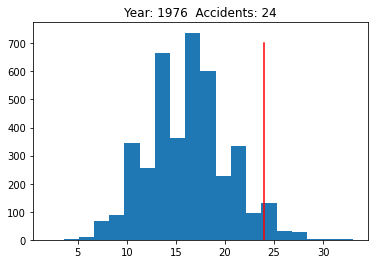

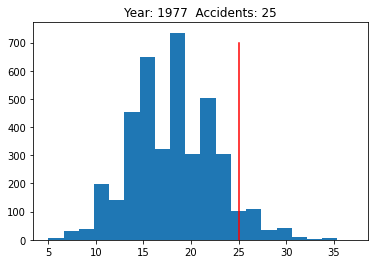

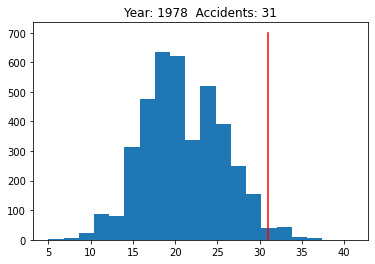

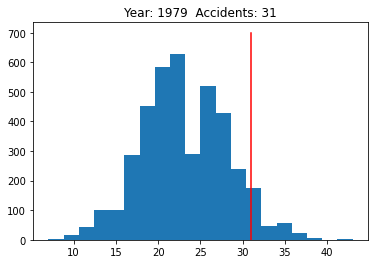

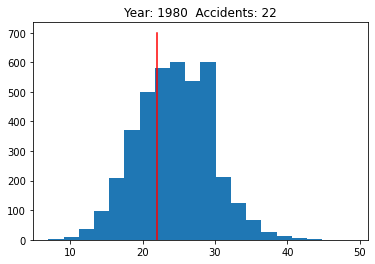

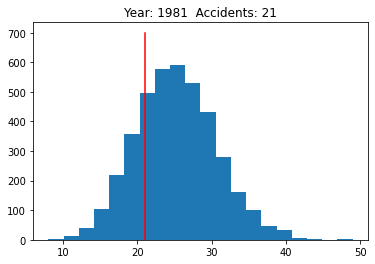

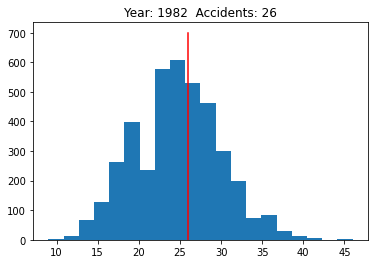

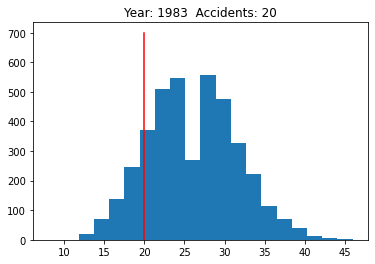

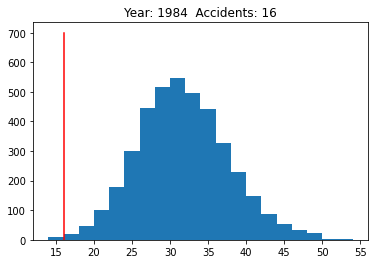

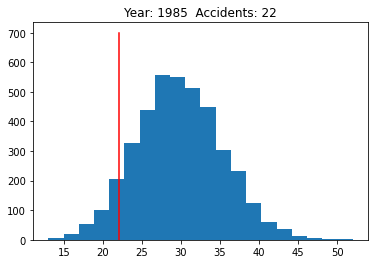

In [245]:
fatal_accidents = Airline_data['Fatal accidents']
years = Airline_data['Year']
for i in range(len(Airline_data)):
    sample = 'y_sim[' + str(i+1) +']'
    plt.hist(sim_4_df[sample], bins=20)
    plt.plot([fatal_accidents[i], fatal_accidents[i]],[0, 700], 'r-')
    plt.title("Year: " + str(years[i]) + "  Accidents: " + str(fatal_accidents[i]))
    plt.show()

In some cases this model underestimates or overestimates the number of fatal accidents each year. It shows us, that amoudt of miles flown in that year is not strongly correlated to the number of accidents.